# Simple question answering

This demo implements a simple form of question answering. Two features (color and shape)
will be bound by circular convolution. A cue will be used to determine either one of the
features by deconvolution.

When you run the network, it will start by binding `RED` and `CIRCLE` for 0.5 seconds
and then binding `BLUE` and `SQUARE` for 0.5 seconds. In parallel the network is asked
with the cue. For example, when the cue is `CIRCLE` the network will respond with `RED`.

In [1]:
%matplotlib inline

import nengo
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0

## Step 1: Define the vocabulary dimension and network

In [2]:
# Number of dimensions for the Semantic Pointers
dimensions = 32

model = spa.Network(label="Simple question answering", seed=seed)

## Step 2: Define the input

The color input will switch every 0.5 seconds between `RED` and `BLUE`. In the same way
the shape input switches between `CIRCLE` and `SQUARE`. Thus, the network will bind
alternatingly `RED * CIRCLE` and `BLUE * SQUARE` for 0.5 seconds each.

The cue for deconvolving bound semantic pointers cycles through `CIRCLE`, `RED`,
`SQUARE`, and `BLUE` within one second.

In [3]:
def color_input(t):
    if (t // 0.5) % 2 == 0:
        return "RED"
    else:
        return "BLUE"


def shape_input(t):
    if (t // 0.5) % 2 == 0:
        return "CIRCLE"
    else:
        return "SQUARE"


def cue_input(t):
    sequence = ["0", "CIRCLE", "RED", "0", "SQUARE", "BLUE"]
    idx = int((t // (1.0 / len(sequence))) % len(sequence))
    return sequence[idx]


with model:
    color_in = spa.Transcode(color_input, output_vocab=dimensions)
    shape_in = spa.Transcode(shape_input, output_vocab=dimensions)
    cue = spa.Transcode(cue_input, output_vocab=dimensions)

## Step 3: Create the model

In [4]:
with model:
    conv = spa.State(dimensions)
    out = spa.State(dimensions)

    # Connect the buffers
    color_in * shape_in >> conv
    conv * ~cue >> out

## Step 4: Probe the output

In [5]:
with model:
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    p_color_in = nengo.Probe(color_in.output)
    p_shape_in = nengo.Probe(shape_in.output)
    p_cue = nengo.Probe(cue.output)
    p_conv = nengo.Probe(conv.output)
    p_out = nengo.Probe(out.output)

## Step 4: Run the model

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(3.0)

## Step 5: Plot the results

Text(0.5, 0, 'time [s]')

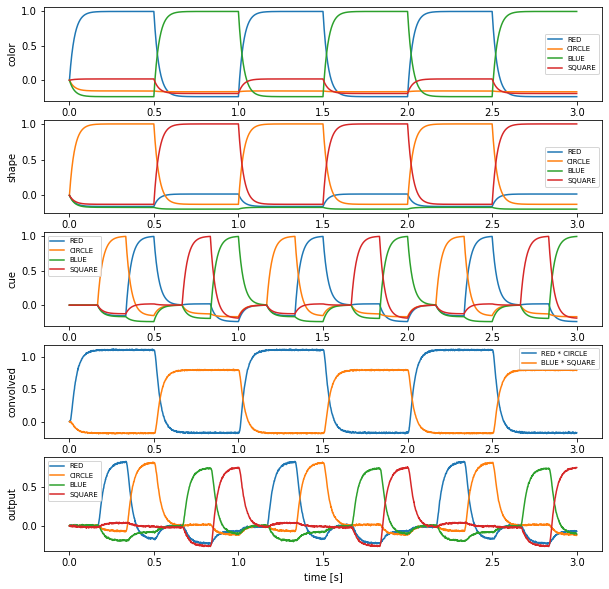

In [7]:
plt.figure(figsize=(10, 10))
vocab = model.vocabs[dimensions]

plt.subplot(5, 1, 1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_color_in], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("color")

plt.subplot(5, 1, 2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_shape_in], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("shape")

plt.subplot(5, 1, 3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_cue], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("cue")

plt.subplot(5, 1, 4)
for pointer in ["RED * CIRCLE", "BLUE * SQUARE"]:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[p_conv].T), label=pointer)
plt.legend(fontsize="x-small")
plt.ylabel("convolved")

plt.subplot(5, 1, 5)
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), fontsize="x-small")
plt.ylabel("output")
plt.xlabel("time [s]")

The last plot shows that the output is most similar to the semantic pointer bound to the
current cue. For example, when `RED` and `CIRCLE` are being convolved and the cue is
`CIRCLE`, the output is most similar to `RED`.